In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
import tensorflow as tf
import tensorflow_datasets as tfds
from jax_lensing.utils import load_dataset
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.models import UResNet18

from astropy.io import fits

In [6]:
dataset = "kappatng"
weight_dir='/gpfswork/rech/xdy/commun/Remy2021/score_sn1.0_std0.2'

gaussian_prior = True
batch_size = 32
map_size = 360
resolution = 0.29
noise_dist_std = 0.2
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [7]:
def forward_fn(x, s, is_training=False):
  denoiser = UResNet18(n_output_channels=1)
  return denoiser(x, s, is_training=is_training)

model = hk.without_apply_rng(hk.transform_with_state(forward_fn))

model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [8]:
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"

# load theoretical power spectrum
ps_data_th = onp.load(gaussian_path).astype('float32')

# calibration
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
#kell_th = ell_th / (360/3.5/0.5) / float(map_size)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
power_map = jnp.array(make_power_map(ps_halofit_th, map_size, kps=kell_th))

In [9]:
def log_gaussian_prior(map_data, sigma, ps_map):
  data_ft = jnp.fft.fft2(map_data) / float(map_size)
  return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))
gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [10]:
def score_fn(params, state, batch, is_training=False):
    if gaussian_prior:
      # If requested, first compute the Gaussian prior
      gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map)
      gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
      net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
      res, state = model.apply(params, state, net_input, batch['s'], is_training=is_training)
    else:
      res, state = model.apply(params, state, batch['y'], batch['s'], is_training=is_training)
      gaussian_score = jnp.zeros_like(res)
    return batch, res, state, gaussian_score

score_fn = partial(score_fn, params, state)

## Try on the test set

In [11]:
def load_dataset(name, batch_size, crop_width, noise_dist_std):
  # for training
  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.image.random_crop(tf.expand_dims(im['map'],-1), [crop_width,crop_width,1])
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    # Sample random Gaussian noise
    u = tf.random.normal(tf.shape(x))
    # Sample standard deviation of noise corruption
    s = noise_dist_std * tf.random.normal((1, 1, 1))
    # Create noisy image
    y = x + s * u
    return {'x':x, 'y':y, 'u':u,'s':s}
  ds = tfds.load(name, split='train[{}:]'.format('-10%'), shuffle_files=True)
  ds = ds.shuffle(buffer_size=10*batch_size)
  ds = ds.repeat()
  ds = ds.map(pre_process)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return iter(tfds.as_numpy(ds))

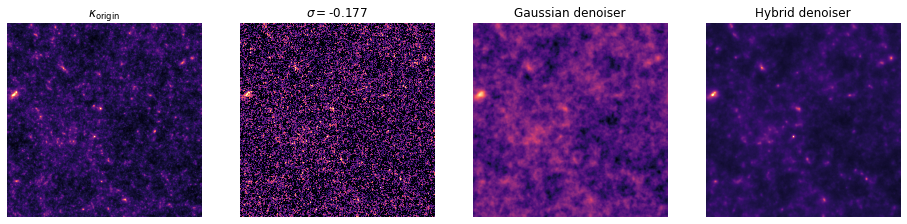

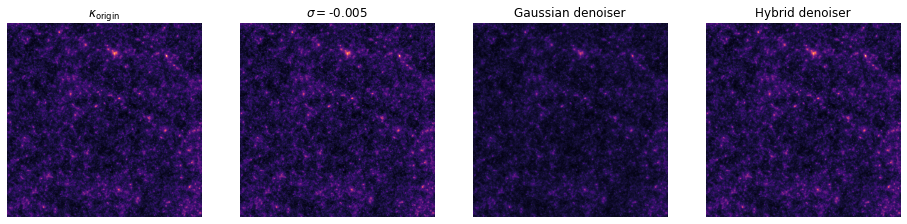

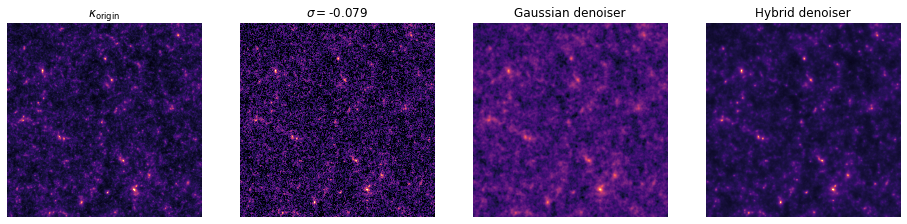

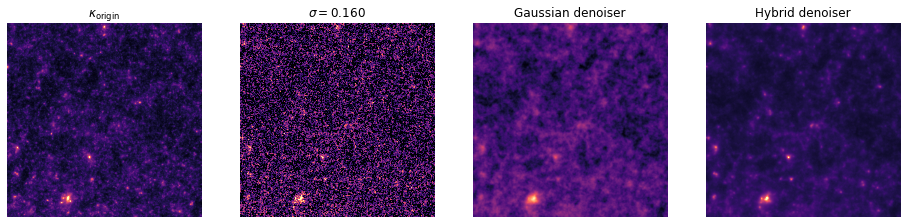

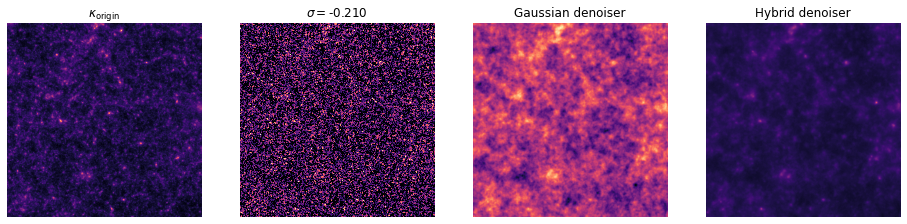

In [12]:
# load convergence maps
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std)
batch = next(train_set)

_, res, state, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title(r'$\kappa_\mathrm{origin}$')
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    title(r"$\sigma=$%.3f"%batch['s'][ind,0,0,0])
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    title('Gaussian denoiser')
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (gaussian_score[ind,...,0]), cmap='magma')
    axis('off')
    subplot(144)
    title('Hybrid denoiser')
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')

## Apply on the validation map

In [13]:
convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
sigma = 0.15
noisy = convergence + sigma*onp.random.randn(360,360)
batch = {'x':convergence.reshape(-1,360,360,1), 'y':noisy.reshape(-1,360,360,1), 's':sigma*jnp.ones((1,1,1,1))}

_, res, state, gaussian_score = score_fn(batch)

In [14]:
ind = 0
gd = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (gaussian_score[ind,...,0])
gddae = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0])
dae = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0])

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# These show the borders of the cosmos field
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

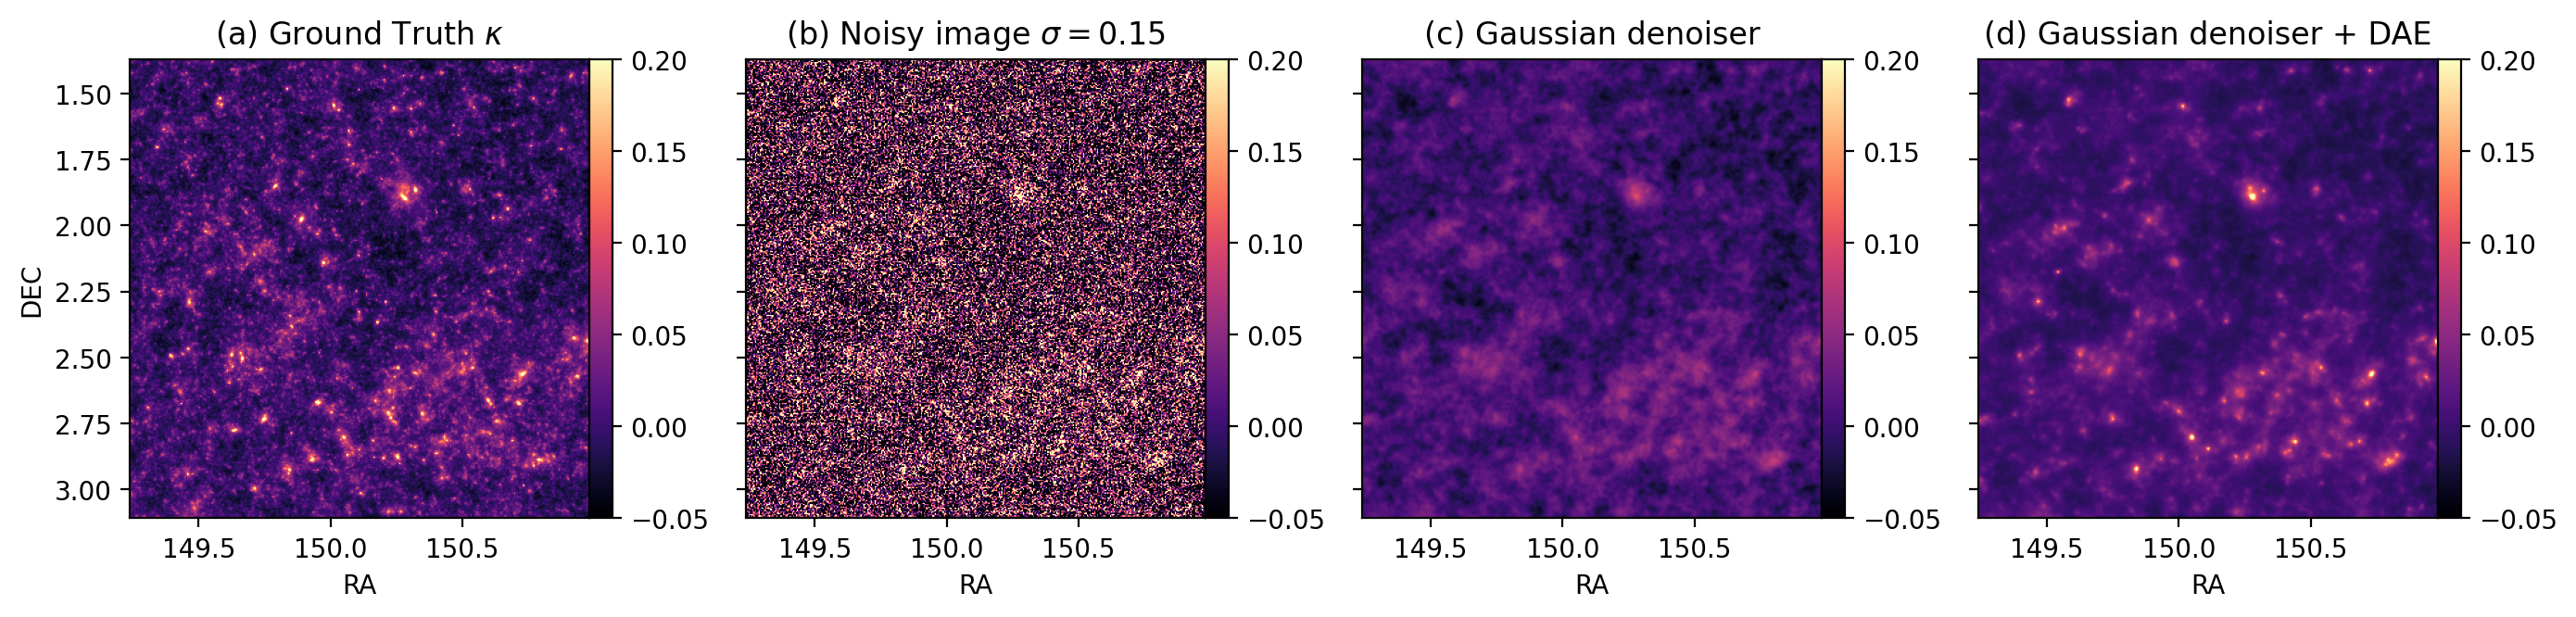

In [20]:
width = 360
resulution = 0.29

vmin = -0.05
vmax = 0.2

f, axes = plt.subplots(1, 4, sharey=True, figsize=(14,5), dpi=200)

# Ground truth
im = axes[0].imshow(convergence, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[0].invert_yaxis()
#axes[0].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
#axes[0].plot(ra, dec,  c='w', lw=1)
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
axes[0].set_title(r'(a) Ground Truth $\kappa$')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.)
f.colorbar(im, cax=cax)

# Noisy image
im = axes[1].imshow(noisy, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[1].invert_yaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
#axes[0].plot(ra, dec,  c='w', lw=1)
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA')
#axes[1].set_ylabel('dec')
axes[1].set_title(r'(b) Noisy image $\sigma=${}'.format(sigma))
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.)
f.colorbar(im, cax=cax)


# Gaussian denosier
im = axes[2].imshow(gd, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[2].invert_yaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
#axes[0].plot(ra, dec,  c='w', lw=1)
axes[2].set_aspect('equal')
axes[2].set_xlabel('RA')
#axes[1].set_ylabel('dec')
axes[2].set_title('(c) Gaussian denoiser')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.)
f.colorbar(im, cax=cax)

# Gaussian + Denoising Auto Encoder denoiser
im = axes[3].imshow(gddae, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto", vmin=vmin, vmax=vmax)
axes[3].invert_yaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
#axes[0].plot(ra, dec,  c='w', lw=1)
axes[3].set_aspect('equal')
axes[3].set_xlabel('RA')
#axes[1].set_ylabel('dec')
axes[3].set_title('(d) Gaussian denoiser + DAE')
divider = make_axes_locatable(axes[3])
cax = divider.append_axes("right", size="5%", pad=0.)
f.colorbar(im, cax=cax)

"""
# DAE output
im = axes[3].imshow(dae, origin='lower', cmap='magma', extent=get_extend_radec(resolution, width), aspect="auto",
                   vmin=0., vmax=0.5)
axes[3].invert_yaxis()
#axes[1].set_xlim(axes[0].gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
#axes[0].plot(ra, dec,  c='w', lw=1)
axes[3].set_aspect('equal')
axes[3].set_xlabel('RA')
#axes[3].set_ylabel('dec')
axes[3].set_title('(d) DAE output')
divider = make_axes_locatable(axes[3])
cax = divider.append_axes("right", size="5%", pad=0.0)
f.colorbar(im, cax=cax)
"""

f.tight_layout()

savefig('./plots/gauss-res-0.15.pdf')